In [1]:
# load packages
using Gurobi, StatsBase, CSV, DataFrames, 
    JuMP, LinearAlgebra, Distributions, Random,
    GLMNet, ScikitLearn, MLBase, CategoricalArrays, Plots,
    Dates, Clustering, Distances, StatsPlots, ProgressMeter

ProgressMeter.ijulia_behavior(:clear);
const GUROBI_ENV = Gurobi.Env();

# load data
function load_csv(path)
    data = CSV.read(path, DataFrame)
   return data
end;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-16


In [2]:
seed = 42
X = load_csv("X.csv");
y = load_csv("y.csv");
y_bin = load_csv("y_binary.csv");

data = hcat(X,y_bin);
X = data[:,2:(end - 1)];
y_bin = data.home_team_result;

## Modelling

In [27]:
(X_train, y_train), (X_test, y_test) = IAI.split_data(:classification, X, y_bin, seed=seed, train_proportion=0.7);

In [33]:
X_train_mat = Matrix(X_train);
X_test_mat = Matrix(X_test);
# scale X_train
dt = fit(ZScoreTransform, X_train_mat);
X_train_scaled = StatsBase.transform(dt, Matrix(X_train));

dt = fit(ZScoreTransform, X_test_mat);
X_test_scaled = StatsBase.transform(dt, Matrix(X_test));

# convert X_scaled into dataframe
X_train_scaled = DataFrame(X_train_scaled, names(X_train));
X_test_scaled = DataFrame(X_test_scaled, names(X_test));

In [47]:
grid = IAI.GridSearch(
    IAI.OptimalFeatureSelectionClassifier(
        random_seed=seed,
        show_progress=false
    ),

    # tried 3:15; best = 4
    # tried 3:11; best = 4
    # tried 1:6; best = 4
    sparsity=3:15, 
)
IAI.fit_cv!(grid, X_train_scaled, y_train, validation_criterion=:auc,n_folds=5);

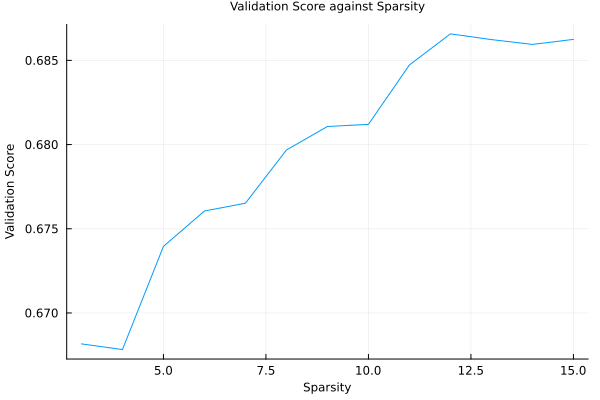

In [48]:
plot(grid, type=:validation)

In [49]:
# variable importacne where importance is non-zero
var_imp = IAI.variable_importance(IAI.get_learner(grid))
var_imp[var_imp[:,2] .!= 0,:]

Row,Feature,Importance
,Symbol,Float64
1,away_team_mean_offense_score,0.127699
2,away_team_mean_midfield_score,0.106843
3,home_team_mean_offense_score,0.100711
4,home_team_mean_midfield_score,0.0975514
5,home_team_total_fifa_points,0.0890152
6,away_team_mean_defense_score,0.0862467
7,home_team_mean_defense_score,0.082406
8,away_team_Brazil,0.0748555
9,away_team_goalkeeper_score,0.0724192


In [53]:
IAI.score(grid, X_test_scaled, y_test, criterion=:auc)

0.7219898565821732

In [54]:
roc = IAI.ROCCurve(grid, X_test_scaled, y_test, positive_label=1)

ROCCurve with AUC 0.722:

 Row │ threshold  tpr         fpr      
     │ Float64    Float64     Float64  
─────┼─────────────────────────────────
   1 │ 1.0        0.0         0.0
   2 │ 0.800997   0.00249377  0.0
   3 │ 0.795804   0.00498753  0.0
   4 │ 0.792487   0.0074813   0.0
   5 │ 0.789047   0.00997506  0.0
   6 │ 0.775122   0.0124688   0.0
   7 │ 0.774054   0.0149626   0.0
   8 │ 0.77234    0.0174564   0.0
  ⋮  │     ⋮          ⋮          ⋮
 869 │ 0.164168   0.997506    0.989451
 870 │ 0.161319   0.997506    0.991561
 871 │ 0.157943   0.997506    0.993671
 872 │ 0.134711   0.997506    0.995781
 873 │ 0.130539   1.0         0.995781
 874 │ 0.127556   1.0         0.99789
 875 │ 0.0895475  1.0         1.0
 876 │ 0.0        1.0         1.0
                       860 rows omitted

In [55]:
IAI.score(grid, X_test_scaled,y_test,criterion=:misclassification)

0.6697142857142857

## Predictions

In [86]:
original_group_df = load_csv("fifa_worldcup_2022_groupstages.csv");

In [87]:
group_df = load_csv("group_stage_X.csv");

In [88]:
group_df[1:5,:]

Row,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_team_Algeria,home_team_Angola,home_team_Argentina,home_team_Australia,home_team_Austria,home_team_Belarus,home_team_Belgium,home_team_Bolivia,home_team_Bosnia and Herzegovina,home_team_Brazil,home_team_Bulgaria,home_team_Burkina Faso,home_team_Cabo Verde,home_team_Cameroon,home_team_Canada,home_team_Chile,home_team_China PR,home_team_Colombia,home_team_Congo,home_team_Congo DR,home_team_Costa Rica,home_team_Croatia,home_team_Cyprus,home_team_Czech Republic,home_team_Côte d'Ivoire,home_team_Denmark,home_team_Ecuador,home_team_Egypt,home_team_England,home_team_Finland,home_team_France,home_team_Georgia,home_team_Germany,home_team_Ghana,home_team_Greece,home_team_Guinea,home_team_Honduras,home_team_Hungary,home_team_IR Iran,home_team_Iceland,home_team_Israel,home_team_Italy,home_team_Jamaica,home_team_Japan,home_team_Korea Republic,home_team_Kosovo,home_team_Lithuania,home_team_Mali,home_team_Mexico,home_team_Montenegro,home_team_Morocco,home_team_Netherlands,home_team_New Zealand,home_team_Nigeria,home_team_North Macedonia,home_team_Northern Ireland,home_team_Norway,home_team_Panama,home_team_Paraguay,home_team_Peru,home_team_Poland,home_team_Portugal,home_team_Republic of Ireland,home_team_Romania,home_team_Russia,home_team_Saudi Arabia,home_team_Scotland,home_team_Senegal,home_team_Serbia,home_team_Slovakia,home_team_Slovenia,home_team_South Africa,home_team_Spain,home_team_Sweden,home_team_Switzerland,home_team_Tunisia,home_team_Turkey,home_team_USA,home_team_Ukraine,home_team_United Arab Emirates,home_team_Uruguay,home_team_Venezuela,home_team_Wales,away_team_Algeria,away_team_Angola,away_team_Argentina,away_team_Australia,away_team_Austria,⋯
,Int64,Int64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,⋯
1,50,44,1439.89,1464.39,77,71,77.5,80.3,77.5,73.5,78.3333,76.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
2,18,8,1584.38,1694.51,83,81,79.5,81.3333,79.0,86.5,83.0,84.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
3,50,18,1439.89,1584.38,77,83,77.5,80.3,77.5,79.5,81.3333,79.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
4,8,44,1694.51,1464.39,81,71,86.5,83.0,84.5,73.5,78.3333,76.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯
5,44,18,1464.39,1584.38,71,83,73.5,78.3333,76.0,79.5,81.3333,79.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,⋯


In [89]:
# scale group_df
group_df_mat = Matrix(group_df);
dt = fit(ZScoreTransform, group_df_mat);
group_df_scaled = StatsBase.transform(dt, Matrix(group_df));
group_df_scaled = DataFrame(group_df_scaled, names(group_df));

In [90]:
# make predictions on group stage
predictions = IAI.predict(grid, group_df_scaled);
prob_predictions = IAI.predict_proba(grid, group_df_scaled);

In [91]:
# append predictions to original_group_df
original_group_df = hcat(original_group_df, predictions);
original_group_df = hcat(original_group_df, prob_predictions);

In [97]:
# group df select home team, away team, prediction
home_away_results = original_group_df[:,[2,3,end-2,end-1,end]]

# confidently predicted losses
home_away_results[home_away_results[:,4] .>= .6,:]

Row,home_team,away_team,x1,0,1
,String15,String15,Int64,Float64,Float64
1,Wales,England,0,0.619676,0.380324
2,Poland,Argentina,0,0.605023,0.394977
3,Saudi Arabia,Mexico,0,0.631726,0.368274
4,Australia,Denmark,0,0.608758,0.391242
5,Tunisia,France,0,0.656174,0.343826
6,Japan,Spain,0,0.621722,0.378278
7,Costa Rica,Germany,0,0.640073,0.359927
8,Cameroon,Brazil,0,0.688787,0.311213
9,Ghana,Uruguay,0,0.609782,0.390218


In [98]:
home_away_results[home_away_results[:,5] .>= .6,:]

Row,home_team,away_team,x1,0,1
,String15,String15,Int64,Float64,Float64
1,Argentina,Saudi Arabia,1,0.370954,0.629046


In [75]:
home_away_results

Row,home_team,away_team,x1
,String15,String15,Int64
1,Qatar,Ecuador,0
2,Senegal,Netherlands,0
3,Qatar,Senegal,0
4,Netherlands,Ecuador,1
5,Ecuador,Senegal,0
6,Netherlands,Qatar,1
7,England,Iran,1
8,USA,Wales,0
9,Wales,Iran,0
